In [144]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.utils import compute_sample_weight

import pickle

from utils import remove_top_quantile

In [145]:
df = pd.read_csv('../data/GiveMeSomeCredit-training.csv')
df = df.drop(["Unnamed: 0"], axis=1)

df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Imputing
We are going to handle missing values with a median imputing strategy. Observe missing  alues in MonthlyIncome and NumberOfDependents.

In [146]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [147]:
imputer = SimpleImputer(strategy='median')

columns = df.columns
index = df.index
df = pd.DataFrame(imputer.fit_transform(df))
df.columns = columns
df.index = index

## Outlier removal

First we have to check skewness of data and then trim ouliers.

SeriousDlqin2yrs 3.4688223830320744
RevolvingUtilizationOfUnsecuredLines 97.63059816725877
age 0.18899265517606081
NumberOfTime30-59DaysPastDueNotWorse 22.59688158749776
DebtRatio 95.15684128495592
MonthlyIncome 127.12042442501006
NumberOfOpenCreditLinesAndLoans 1.2153016270332535
NumberOfTimes90DaysLate 23.08711459783684
NumberRealEstateLoansOrLines 3.4824491685802634
NumberOfTime60-89DaysPastDueNotWorse 23.331509801434684
NumberOfDependents 1.6260425072931113


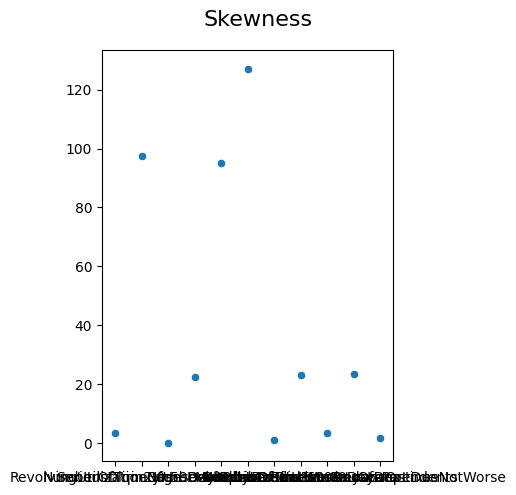

In [148]:
columns = df.columns.to_list()
skew_values = skew(df)

for c, v in zip(columns, skew_values):
    print(c, v)


f, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
f.suptitle('Skewness', fontsize=16)

sns.scatterplot(x=columns, y=skew_values)

plt.tight_layout()
plt.show()

We can observe big imbalance in variables denoting number of times customer had late payments. We are not going to trim those variables as they might be of an importance later.

Instead, we are going to trim variables RevolvingUtilizationOfUnsecuredLines, DebtRatio and MonthlyIncome, as per notebook part 1 EDA.

In [149]:
df = remove_top_quantile(df, "RevolvingUtilizationOfUnsecuredLines", 0.99)
df = remove_top_quantile(df, "DebtRatio", 0.99)
df = remove_top_quantile(df, "MonthlyIncome", 0.99)

In [150]:
columns = df.columns.to_list()
skew_values = skew(df)

for c, v in zip(columns, skew_values):
    print(c, v)

SeriousDlqin2yrs 3.5784960473809213
RevolvingUtilizationOfUnsecuredLines 0.9262920695519816
age 0.18849615488405877
NumberOfTime30-59DaysPastDueNotWorse 22.355581145012955
DebtRatio 3.314854561573002
MonthlyIncome 1.3775576751904228
NumberOfOpenCreditLinesAndLoans 1.207810536108503
NumberOfTimes90DaysLate 22.841710680299524
NumberRealEstateLoansOrLines 3.0080346901559394
NumberOfTime60-89DaysPastDueNotWorse 23.04674925646731
NumberOfDependents 1.6368869235710068


## Feature engineering
Variables NumberOfTime30-59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse and NumberOfTimes90DaysLate will be converted to a single categorical variable indicating level of "lateness". 

In [151]:
# todo
def f(a):
    # never late
    if a["NumberOfTime30-59DaysPastDueNotWorse"] == 0 and \
        a["NumberOfTime60-89DaysPastDueNotWorse"] == 0 and \
        a["NumberOfTimes90DaysLate"] == 0:
            return 0
    # 30-59 late
    if a["NumberOfTime30-59DaysPastDueNotWorse"] != 0 and \
        a["NumberOfTime60-89DaysPastDueNotWorse"] == 0 and \
        a["NumberOfTimes90DaysLate"] == 0:
            return 1
    # 60-89 late
    if a["NumberOfTime30-59DaysPastDueNotWorse"] != 0 and \
        a["NumberOfTime60-89DaysPastDueNotWorse"] != 0 and \
        a["NumberOfTimes90DaysLate"] == 0:
            return 2
    # 90+ late
    return 3


df["PastDueSevereness"] = df.apply(f, axis=1)

## Scaling
Data will be scaled using a standard scaler.

In [152]:
scaler = StandardScaler()
df[['age',
    'NumberOfDependents',
    'MonthlyIncome',
    'DebtRatio', 
    'RevolvingUtilizationOfUnsecuredLines', 
    'NumberOfOpenCreditLinesAndLoans', 
    'NumberRealEstateLoansOrLines'
]] = scaler.fit_transform(
    df[['age',
        'NumberOfDependents',
        'MonthlyIncome',
        'DebtRatio', 
        'RevolvingUtilizationOfUnsecuredLines', 
        'NumberOfOpenCreditLinesAndLoans', 
        'NumberRealEstateLoansOrLines'
    ]])